In [1]:
import pandas as pd

from LTSFTransformer import LTSFQuantileTransformerEncoderOnly
from preprocess import prepare_for_quantile_transformer
from model import train_one_epoch, evaluate
from model import build_cfg_from_prepared
from typing import Dict, Any, Optional, Tuple
import os, json, pickle
from dataclasses import asdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

In [2]:
from preprocess import split_last_full_days

df = pd.read_csv("raw_data/raw_data_merged.csv")
df["isp"] = (
    pd.to_numeric(df["isp"], errors="coerce")
    .clip(lower=-1000, upper=1000)
)

df_cut,last = split_last_full_days(df)
prepared = prepare_for_quantile_transformer(
    df=df_cut,
    target_col="isp",
    L=96*7,     # napr. 7 dní histórie (7*96 = 672)
    H=96,       # 1 deň dopredu
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# infer lookback and input dim from prepared arrays
lookback = prepared.arrays["train"]["X_hist"].shape[1]   # L
d_enc_in = prepared.arrays["train"]["X_hist"].shape[2]   # number of features per timestep

from LTSFTransformer import LTSFQuantileEncoderConfig

cfg = LTSFQuantileEncoderConfig(
    lookback=lookback,
    horizon=96,
    c_in=d_enc_in,
    d_model=128,
    nhead=8,
    num_layers=4,
    readout="last",
    crossing_penalty_weight=0.0,
)
print("lookback:", lookback, "c_in:", d_enc_in)


lookback: 672 c_in: 69


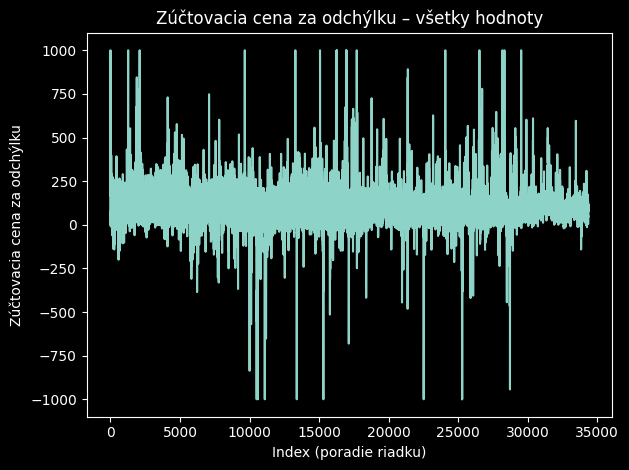

In [5]:
y = pd.to_numeric(df["isp"], errors="coerce").dropna()

plt.figure()
plt.plot(y.values)  # x = 0..N-1, y = hodnoty
plt.xlabel("Index (poradie riadku)")
plt.ylabel("Zúčtovacia cena za odchýlku")
plt.title("Zúčtovacia cena za odchýlku – všetky hodnoty")
plt.tight_layout()
plt.show()

In [6]:
def save_bundle(
    path: str,
    model: torch.nn.Module,
    cfg,  # QuantileTransformerConfig
    feature_cols: Dict[str, Any],
    scalers: Dict[str, Any],
    extra: Optional[Dict[str, Any]] = None,
) -> None:
    """
    Uloží:
      - model.state_dict()
      - cfg (asdict)
      - feature_cols (napr. prepared.feature_cols)
      - scalers (prepared.scalers) cez pickle
      - extra metadata (voliteľné)
    """
    os.makedirs(path, exist_ok=True)

    # 1) model weights
    torch.save(model.state_dict(), os.path.join(path, "model_state.pt"))

    # 2) cfg + feature cols + extra do JSON
    meta = {
        "cfg": asdict(cfg),
        "feature_cols": feature_cols,
        "extra": extra or {},
    }
    with open(os.path.join(path, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    # 3) scalers pickle
    with open(os.path.join(path, "scalers.pkl"), "wb") as f:
        pickle.dump(scalers, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_bundle(
    path: str,
    model_class,  # QuantileEncoderDecoderTransformer
    cfg_class,    # QuantileTransformerConfig
    device: torch.device,
) -> Tuple[torch.nn.Module, Any, Dict[str, Any], Dict[str, Any]]:
    """
    Načíta bundle a vráti: (model, cfg, feature_cols, scalers)
    """
    meta_path = os.path.join(path, "meta.json")
    state_path = os.path.join(path, "model_state.pt")
    scalers_path = os.path.join(path, "scalers.pkl")

    if not os.path.exists(meta_path) or not os.path.exists(state_path) or not os.path.exists(scalers_path):
        raise FileNotFoundError(f"Missing bundle files in: {path}")

    with open(meta_path, "r", encoding="utf-8") as f:
        meta = json.load(f)

    cfg = cfg_class(**meta["cfg"])
    feature_cols = meta["feature_cols"]

    with open(scalers_path, "rb") as f:
        scalers = pickle.load(f)

    model = model_class(cfg).to(device)
    state = torch.load(state_path, map_location=device)
    model.load_state_dict(state)
    model.eval()

    return model, cfg, feature_cols, scalers


In [7]:
bundle_dir = "artifacts/qt_transformer_v1"

In [8]:
model = LTSFQuantileTransformerEncoderOnly(cfg).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-4)

# Override train_one_epoch/evaluate for encoder-only model (ignores X_fut)
def train_one_epoch(model, loader, optimizer, device, grad_clip: float = 1.0) -> float:
    model.train()
    total = 0.0
    n = 0
    for batch in loader:
        optimizer.zero_grad(set_to_none=True)

        if len(batch) == 2:
            x_hist, y_true = batch
        else:
            x_hist, _x_fut, y_true = batch  # ignore future covariates for encoder-only model

        x_hist = x_hist.to(device)
        y_true = y_true.to(device)

        yhat_q = model(x_hist)  # (B,H,Q)
        loss = model.loss(y_true, yhat_q)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        total += float(loss.detach().cpu())
        n += 1
    return total / max(n, 1)


@torch.no_grad()
def evaluate(model, loader, device) -> float:
    model.eval()
    total = 0.0
    n = 0
    for batch in loader:
        if len(batch) == 2:
            x_hist, y_true = batch
        else:
            x_hist, _x_fut, y_true = batch

        x_hist = x_hist.to(device)
        y_true = y_true.to(device)

        yhat_q = model(x_hist)
        loss = model.loss(y_true, yhat_q)

        total += float(loss.detach().cpu())
        n += 1
    return total / max(n, 1)


def format_seconds(s: float) -> str:
    m = int(s // 60)
    sec = s - 60 * m
    return f"{m:02d}:{sec:04.1f}"


def train_model(
    model,
    prepared,
    cfg,
    device,
    epochs: int = 10,
    lr: float = 3e-4,
    grad_clip: float = 1.0,
    bundle_dir: Optional[str] = None,
):
    """
    Trénuje model a (voliteľne) ukladá najlepší checkpoint podľa val loss.

    Vypisované metriky:
      - train_loss: priemerný pinball loss (a prípadne crossing penalty) na tréningových batchoch
      - val_loss:   to isté na validačných batchoch
      - best_val:   najlepšia validačná hodnota doteraz
    """
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    best_val = float("inf")

    print("Training started")
    print(f"  epochs        : {epochs}")
    print(f"  lr            : {lr}")
    print(f"  grad_clip     : {grad_clip}")
    print(f"  horizon (H)   : {cfg.horizon}")
    print(f"  quantiles (Q) : {len(cfg.quantiles)} -> {list(cfg.quantiles)}")
    print(f"  scale_target  : {'y' in prepared.scalers} (loss is computed on scaled target if True)")
    print("-" * 90)
    print(
        f"{'epoch':>5} | {'train_loss':>10} | {'val_loss':>10} | {'best_val':>10} | {'Δ val':>10} | {'time':>7} | note"
    )
    print("-" * 90)

    for epoch in range(epochs):
        t0 = time.time()

        tr = train_one_epoch(model, prepared.train_loader, opt, device, grad_clip=grad_clip)
        va = evaluate(model, prepared.val_loader, device)

        dt = time.time() - t0
        delta = va - best_val

        improved = va < best_val
        note = "✅ improved" if improved else "—"

        if improved:
            best_val = va
            delta_str = f"{delta: .3e}" if epoch > 0 else "   n/a"
            # uložiť checkpoint iba pri zlepšení
            if bundle_dir is not None:
                save_bundle(
                    path=bundle_dir,
                    model=model,
                    cfg=cfg,
                    feature_cols=prepared.feature_cols,
                    scalers=prepared.scalers,
                    extra={
                        "best_val": float(best_val),
                        "epoch": int(epoch),
                        "target_col": prepared.feature_cols["target"][0],
                        "L": int(prepared.arrays["train"]["X_hist"].shape[1]),
                        "H": int(cfg.horizon),
                        "notes": "Quantile encoder-decoder transformer (best checkpoint)",
                    },
                )
        else:
            delta_str = f"{delta: .3e}"

        print(
            f"{epoch:5d} | {tr:10.6f} | {va:10.6f} | {best_val:10.6f} | {delta_str:>10} | {format_seconds(dt):>7} | {note}"
        )

    print("-" * 90)
    print(f"Done. Best val_loss = {best_val:.6f}")
    return best_val

/home/mremen/.virtualenvs/transformer/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [9]:
best_val = train_model(
    model=model,
    prepared=prepared,
    cfg=cfg,
    device=device,
    epochs=20,
    lr=3e-4,
    grad_clip=1.0,
    bundle_dir=bundle_dir,  # ukladá len keď sa zlepší
)

Training started
  epochs        : 20
  lr            : 0.0003
  grad_clip     : 1.0
  horizon (H)   : 96
  quantiles (Q) : 9 -> [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9]
  scale_target  : True (loss is computed on scaled target if True)
------------------------------------------------------------------------------------------
epoch | train_loss |   val_loss |   best_val |      Δ val |    time | note
------------------------------------------------------------------------------------------
    0 |   0.305755 |   0.365445 |   0.365445 |        n/a | 00:35.1 | ✅ improved
    1 |   0.262909 |   0.350320 |   0.350320 | -1.512e-02 | 00:33.8 | ✅ improved
    2 |   0.254084 |   0.346517 |   0.346517 | -3.803e-03 | 00:33.7 | ✅ improved
    3 |   0.249896 |   0.341696 |   0.341696 | -4.821e-03 | 00:33.7 | ✅ improved
    4 |   0.246710 |   0.341048 |   0.341048 | -6.475e-04 | 00:33.7 | ✅ improved
    5 |   0.243062 |   0.338792 |   0.338792 | -2.

In [10]:
# po treningu
save_bundle(
    path=bundle_dir,
    model=model,
    cfg=cfg,
    feature_cols=prepared.feature_cols,
    scalers=prepared.scalers,
    extra={
        "target_col": "isp",
        "L": 96*7,
        "H": 96,
        "notes": "Quantile encoder-decoder transformer",
    }
)
print("Saved to:", bundle_dir)


Saved to: artifacts/qt_transformer_v1


In [11]:
def _inverse_scale_y(y_scaled: np.ndarray, y_scaler) -> np.ndarray:
    if y_scaler is None:
        return y_scaled
    shp = y_scaled.shape
    flat = y_scaled.reshape(-1, 1)
    inv = y_scaler.inverse_transform(flat).reshape(shp)
    return inv

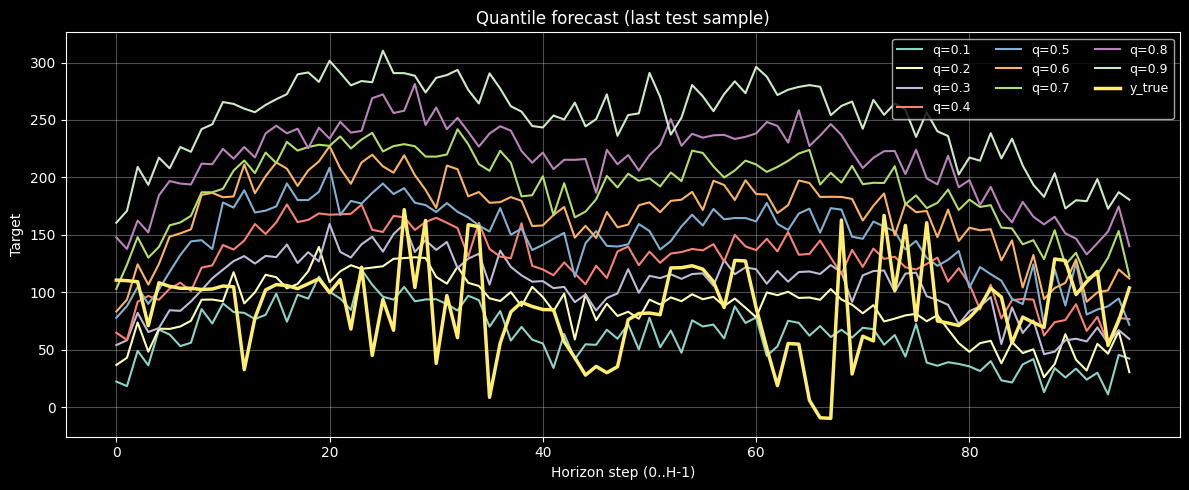

In [12]:
@torch.no_grad()
def predict_one_sample(
    model,
    prepared,
    device,
    split: str = "test",
    sample_idx: int = -1,  # -1 = posledný sample
):
    """
    Vráti (yhat_q, y_true) v *pôvodných jednotkách*.
    yhat_q: (H, Q)
    y_true: (H,)
    """
    model.eval()

    arrays = prepared.arrays[split]
    X_hist = arrays["X_hist"]
    X_fut  = arrays["X_fut"]
    Y_fut  = arrays["Y_fut"]

    # vyber sample
    x_hist = X_hist[sample_idx]            # (L, d_enc)
    y_true = Y_fut[sample_idx]             # (H,)
    x_fut  = None if X_fut is None else X_fut[sample_idx]  # (H, d_dec)

    # torch batch dim
    x_hist_t = torch.from_numpy(x_hist).unsqueeze(0).to(device)  # (1,L,d_enc)
    x_fut_t  = None if x_fut is None else torch.from_numpy(x_fut).unsqueeze(0).to(device)

    # forward
    yhat_q_t = model(x_hist_t, x_fut_t)    # (1,H,Q)
    yhat_q = yhat_q_t.squeeze(0).detach().cpu().numpy()  # (H,Q)

    # inverse scale target
    y_scaler = prepared.scalers.get("y", None)
    yhat_q = _inverse_scale_y(yhat_q, y_scaler)  # (H,Q)
    y_true = _inverse_scale_y(y_true, y_scaler)  # (H,)

    return yhat_q, y_true


def plot_quantile_forecast(
    yhat_q: np.ndarray,
    quantiles,
    y_true: np.ndarray = None,
    title: str = "Quantile forecast",
):
    """
    yhat_q: (H, Q)
    quantiles: list/array length Q
    y_true: (H,) optional
    """
    H, Q = yhat_q.shape
    x = np.arange(H)

    plt.figure(figsize=(12, 5))
    # kvantilové krivky
    for j, q in enumerate(quantiles):
        plt.plot(x, yhat_q[:, j], label=f"q={q:.1f}")

    # skutočnosť
    if y_true is not None:
        plt.plot(x, y_true, linewidth=2.5, label="y_true")

    plt.title(title)
    plt.xlabel("Horizon step (0..H-1)")
    plt.ylabel("Target")
    plt.legend(ncol=3, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# --- použitie (ak už máš model a prepared) ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

yhat_q, y_true = predict_one_sample(model, prepared, device, split="test", sample_idx=-1)

quantiles = list(cfg.quantiles)  # alebo model.quantiles.cpu().numpy().tolist()
plot_quantile_forecast(
    yhat_q=yhat_q,
    quantiles=quantiles,
    y_true=y_true,
    title="Quantile forecast (last test sample)",
)


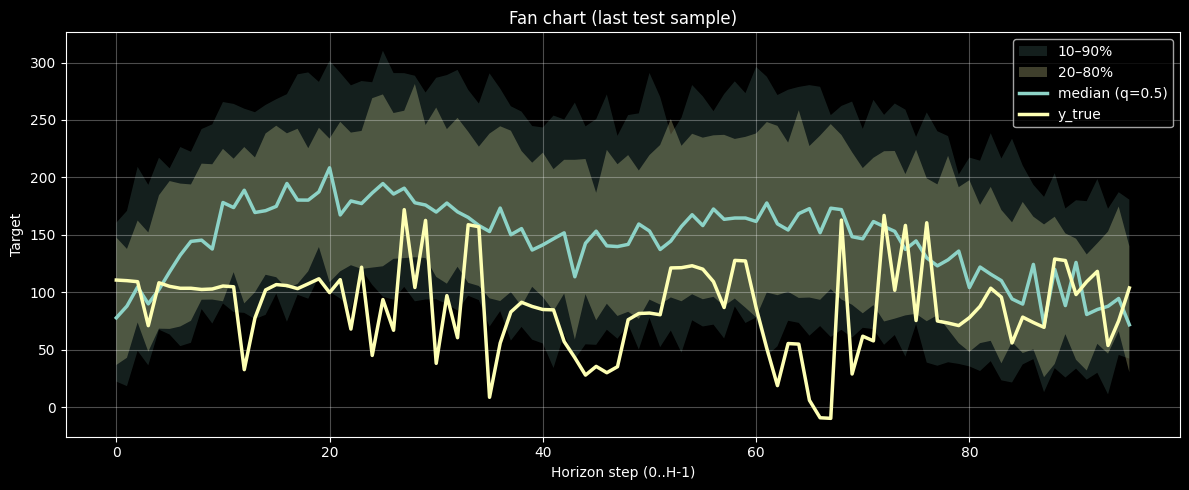

In [13]:
def plot_fan_chart(yhat_q: np.ndarray, quantiles, y_true: np.ndarray = None, title="Quantile fan chart"):
    H, Q = yhat_q.shape
    x = np.arange(H)

    q = np.array(quantiles)
    def get_q(level):
        j = int(np.where(np.isclose(q, level))[0][0])
        return yhat_q[:, j]

    q10 = get_q(0.1); q25 = get_q(0.2) if 0.2 in q else None
    q50 = get_q(0.5); q75 = get_q(0.8) if 0.8 in q else None
    q90 = get_q(0.9)

    plt.figure(figsize=(12, 5))
    # pásma
    plt.fill_between(x, q10, q90, alpha=0.15, label="10–90%")
    if q25 is not None and q75 is not None:
        plt.fill_between(x, q25, q75, alpha=0.25, label="20–80%")

    # medián
    plt.plot(x, q50, linewidth=2.5, label="median (q=0.5)")

    if y_true is not None:
        plt.plot(x, y_true, linewidth=2.5, label="y_true")

    plt.title(title)
    plt.xlabel("Horizon step (0..H-1)")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_fan_chart(yhat_q, quantiles, y_true, title="Fan chart (last test sample)")


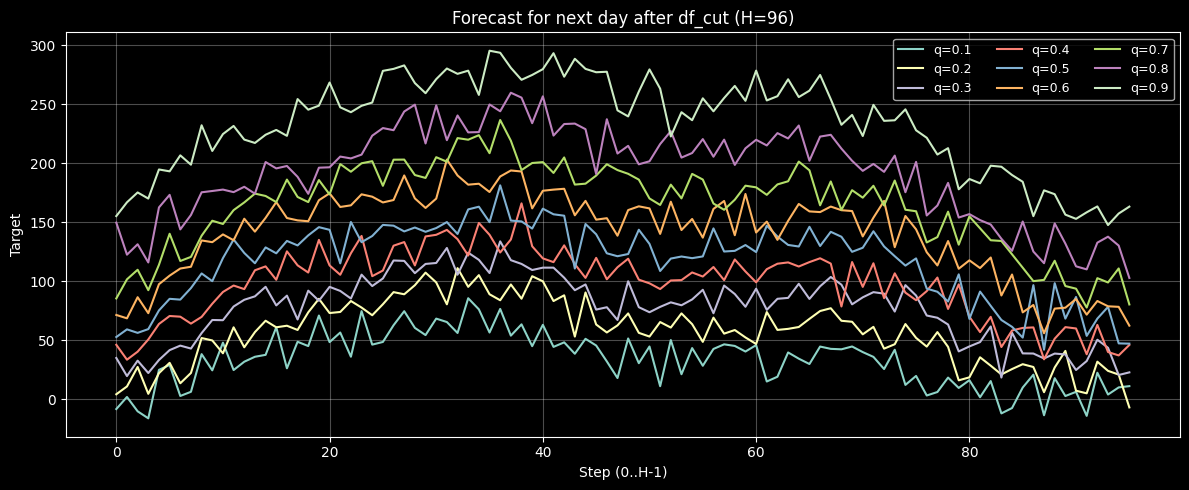

In [14]:
from preprocess import add_time_features_15min, add_lag_features


@torch.no_grad()
def predict_next_day_from_dfcut(work_df_cut: pd.DataFrame, prepared, model, cfg, device,
                                period_col="period_end", tz=None):
    """
    Vezme posledné okno z df_cut a predikuje ďalších H krokov.
    Vracia yhat_q (H,Q) v pôvodných jednotkách.
    """
    # Urob rovnaké feature engineering kroky ako v prepare_for_quantile_transformer,
    # ale použijeme presne tie stĺpce, ktoré si mal uložené v prepared.feature_cols.
    tmp = work_df_cut.copy()
    tmp[period_col] = pd.to_datetime(tmp[period_col])
    tmp = tmp.sort_values(period_col).set_index(period_col)

    # replikujeme minimum z prepare:
    if "Stav sustavy" in tmp.columns and tmp["Stav sustavy"].dtype == object:
        dummies = pd.get_dummies(tmp["Stav sustavy"], prefix="state", dtype=np.float32)
        tmp = tmp.drop(columns=["Stav sustavy"]).join(dummies)

    tmp = add_time_features_15min(tmp, tz=tz)
    tmp = add_lag_features(tmp, target_col=prepared.feature_cols["target"][0])

    enc_cols = prepared.feature_cols["enc"]
    dec_cols = prepared.feature_cols["dec"]
    L = cfg.horizon * 7  # u teba 96*7; ak chceš presne, môžeš ho uložiť do extra a čítať odtiaľ

    # Pozor: L nevieme z cfg, takže lepšie zober z prepared:
    L = prepared.arrays["train"]["X_hist"].shape[1]
    H = cfg.horizon

    tmp = tmp.dropna()
    if len(tmp) < L:
        raise ValueError("Not enough rows after feature engineering/dropna for last window.")

    # posledné historické okno
    X_hist_last = tmp[enc_cols].to_numpy(dtype=np.float32)[-L:]                 # (L, d_enc)

    # budúce kovariáty (kalendár) na nasledujúcich H krokov:
    # vytvoríme budúci index po konci df_cut
    last_ts = tmp.index[-1]
    freq = pd.infer_freq(tmp.index) or "15min"
    fut_index = pd.date_range(last_ts + pd.Timedelta(freq), periods=H, freq=freq)

    fut_df = pd.DataFrame(index=fut_index)
    fut_df = add_time_features_15min(fut_df, tz=tz)
    X_fut_last = fut_df[dec_cols].to_numpy(dtype=np.float32)                    # (H, d_dec)

    # škálovanie podľa prepared.scalers
    if "enc" in prepared.scalers:
        enc_scaler = prepared.scalers["enc"]
        X_hist_last = enc_scaler.transform(X_hist_last)

    if "dec" in prepared.scalers and X_fut_last is not None:
        dec_scaler = prepared.scalers["dec"]
        X_fut_last = dec_scaler.transform(X_fut_last)

    # torch + forward
    xh = torch.from_numpy(X_hist_last).unsqueeze(0).to(device)                  # (1,L,d_enc)
    xf = torch.from_numpy(X_fut_last).unsqueeze(0).to(device)                   # (1,H,d_dec)

    yhat_q = model(xh, xf).squeeze(0).cpu().numpy()                             # (H,Q)

    # inverse scale y
    y_scaler = prepared.scalers.get("y", None)
    yhat_q = _inverse_scale_y(yhat_q, y_scaler)

    return fut_index, yhat_q

def plot_quantiles(yhat_q: np.ndarray, quantiles, title="Quantile forecast"):
    H, Q = yhat_q.shape
    x = np.arange(H)
    plt.figure(figsize=(12,5))
    for j, q in enumerate(quantiles):
        plt.plot(x, yhat_q[:, j], label=f"q={q:.1f}")
    plt.title(title)
    plt.xlabel("Step (0..H-1)")
    plt.ylabel("Target")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=3, fontsize=9)
    plt.tight_layout()
    plt.show()

fut_index, yhat_q = predict_next_day_from_dfcut(df_cut, prepared, model, cfg, device, tz=None)
plot_quantiles(yhat_q, list(cfg.quantiles), title="Forecast for next day after df_cut (H=96)")

In [15]:
import numpy as np
import torch

@torch.no_grad()
def test_bias_summary(model, prepared, device, q=0.5):
    model.eval()
    q_list = model.quantiles.detach().cpu().numpy().tolist()
    j = int(np.where(np.isclose(q_list, q))[0][0])

    y_scaler = prepared.scalers.get("y", None)

    diffs = []
    for batch in prepared.test_loader:
        if len(batch) == 2:
            x_hist, y_true = batch
            x_fut = None
        else:
            x_hist, x_fut, y_true = batch
            x_fut = x_fut.to(device)

        x_hist = x_hist.to(device)
        y_true = y_true.to(device)

        yhat_q = model(x_hist, x_fut)  # (B,H,Q)
        yhat = yhat_q[..., j].detach().cpu().numpy()
        yt   = y_true.detach().cpu().numpy()

        # inverse scale
        if y_scaler is not None:
            yhat = _inverse_scale_y(yhat, y_scaler)
            yt   = _inverse_scale_y(yt, y_scaler)

        diffs.append((yhat - yt).reshape(-1))

    diffs = np.concatenate(diffs)
    print("median error (q50):", np.median(diffs))
    print("mean error (q50):  ", np.mean(diffs))
    print("% under (q50):     ", np.mean(diffs < 0))

test_bias_summary(model, prepared, device, q=0.5)


median error (q50): 0.33164215
mean error (q50):   1140.2446
% under (q50):      0.49741089876033057


In [16]:
@torch.no_grad()
def coverage_check(model, prepared, device, lo=0.1, hi=0.9):
    q_list = model.quantiles.detach().cpu().numpy().tolist()
    i_lo = int(np.where(np.isclose(q_list, lo))[0][0])
    i_hi = int(np.where(np.isclose(q_list, hi))[0][0])

    y_scaler = prepared.scalers.get("y", None)

    above_hi = []
    for batch in prepared.test_loader:
        if len(batch) == 2:
            x_hist, y_true = batch
            x_fut = None
        else:
            x_hist, x_fut, y_true = batch
            x_fut = x_fut.to(device)

        x_hist = x_hist.to(device)
        y_true = y_true.to(device)

        yhat_q = model(x_hist, x_fut).detach().cpu().numpy()
        yt = y_true.detach().cpu().numpy()

        y_lo = yhat_q[..., i_lo]
        y_hi = yhat_q[..., i_hi]

        if y_scaler is not None:
            yt   = _inverse_scale_y(yt, y_scaler)
            y_lo = _inverse_scale_y(y_lo, y_scaler)
            y_hi = _inverse_scale_y(y_hi, y_scaler)

        above_hi.append((yt > y_hi).reshape(-1))

    above_hi = np.concatenate(above_hi)
    print("P(y_true > q0.9) =", above_hi.mean(), " (ideál ~0.10)")

coverage_check(model, prepared, device)


P(y_true > q0.9) = 0.09676738980716254  (ideál ~0.10)


In [17]:
y_scaler = prepared.scalers.get("y", None)

train_y = prepared.arrays["train"]["Y_fut"]
test_y  = prepared.arrays["test"]["Y_fut"]

train_y = _inverse_scale_y(train_y, y_scaler)
test_y  = _inverse_scale_y(test_y, y_scaler)

print("train median:", np.median(train_y), " test median:", np.median(test_y))
print("train mean:  ", np.mean(train_y),   " test mean:  ", np.mean(test_y))


train median: 84.9361  test median: 99.41
train mean:   98.833084  test mean:   108.65218


In [18]:

def plot_fan_chart(
    yhat_q: np.ndarray,
    quantiles,
    y_true: np.ndarray = None,
    title: str = "Quantile fan chart",
    ax=None,
):
    """
    yhat_q: (H,Q)
    y_true: (H,) alebo None
    """
    H, Q = yhat_q.shape
    x = np.arange(H)

    q = np.array(quantiles, dtype=float)

    def get_q(level: float):
        idx = np.where(np.isclose(q, level))[0]
        if len(idx) == 0:
            return None
        return yhat_q[:, int(idx[0])]

    q10 = get_q(0.1)
    q20 = get_q(0.2)
    q50 = get_q(0.5)
    q80 = get_q(0.8)
    q90 = get_q(0.9)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))

    # pásma
    if q10 is not None and q90 is not None:
        ax.fill_between(x, q10, q90, alpha=0.15, label="10–90%")
    if q20 is not None and q80 is not None:
        ax.fill_between(x, q20, q80, alpha=0.25, label="20–80%")

    # medián
    if q50 is not None:
        ax.plot(x, q50, linewidth=2.5, label="median (q=0.5)")

    # truth
    if y_true is not None:
        ax.plot(x, y_true, linewidth=2.5, label="y_true")

    ax.set_title(title)
    ax.set_xlabel("Horizon step (0..H-1)")
    ax.set_ylabel("Target")
    ax.grid(True, alpha=0.3)

    return ax

In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def _coverage_per_q(y_true: np.ndarray, yhat_q: np.ndarray, quantiles) -> dict:
    """
    y_true: (N,H)
    yhat_q: (N,H,Q)
    returns: {q: coverage}
    """
    q = np.array(quantiles, dtype=float)
    cov = {}
    for j, qq in enumerate(q):
        cov[float(qq)] = float(np.mean(y_true <= yhat_q[..., j]))
    return cov

def _interval_stats(y_true: np.ndarray, yhat_q: np.ndarray, quantiles, lo: float, hi: float):
    q = np.array(quantiles, dtype=float)
    j_lo = np.where(np.isclose(q, lo))[0]
    j_hi = np.where(np.isclose(q, hi))[0]
    if len(j_lo) == 0 or len(j_hi) == 0:
        return None

    lo_hat = yhat_q[..., int(j_lo[0])]
    hi_hat = yhat_q[..., int(j_hi[0])]
    inside = (y_true >= lo_hat) & (y_true <= hi_hat)
    coverage = float(np.mean(inside))
    width = float(np.mean(hi_hat - lo_hat))
    return {"coverage": coverage, "mean_width": width}

@torch.no_grad()
def predict_and_plot_last_7_days(
    model,
    prepared,
    device,
    split: str = "test",
    days: int = 7,
    steps_per_day: int = 96,
    quantiles=None,
    suptitle: str = "Fan charts – last 7 days",
):
    """
    Urobí 7 predikcií (každá 1 deň = H=96 horizont),
    vyhodnotí coverage + interval coverage/width a vykreslí 7 fan chartov.
    """
    model.eval()

    arrays = prepared.arrays[split]
    X_hist = arrays["X_hist"]
    X_fut  = arrays.get("X_fut", None)
    Y_fut  = arrays["Y_fut"]

    N = len(X_hist)
    n_needed = days * steps_per_day
    if N < n_needed:
        raise ValueError(f"Not enough samples in split='{split}'. Need >= {n_needed}, have {N}.")

    # vyberieme 7 "denných štartov" z posledných 7 dní
    start = N - n_needed
    sample_indices = [start + i * steps_per_day for i in range(days)]

    # ak quantiles neboli dodané, zober z modelu
    if quantiles is None:
        quantiles = model.quantiles.detach().cpu().numpy().tolist()

    y_scaler = prepared.scalers.get("y", None)

    yhats = []
    ytrues = []

    for k, idx in enumerate(sample_indices):
        x_hist = X_hist[idx]                       # (L,d_enc)
        y_true = Y_fut[idx]                        # (H,)
        x_fut  = None if X_fut is None else X_fut[idx]  # (H,d_dec)

        x_hist_t = torch.from_numpy(x_hist).unsqueeze(0).to(device)
        x_fut_t  = None if x_fut is None else torch.from_numpy(x_fut).unsqueeze(0).to(device)

        yhat_q_t = model(x_hist_t, x_fut_t)        # (1,H,Q)
        yhat_q = yhat_q_t.squeeze(0).cpu().numpy() # (H,Q)

        # inverse scale do pôvodných jednotiek
        yhat_q = _inverse_scale_y(yhat_q, y_scaler)
        y_true = _inverse_scale_y(y_true, y_scaler)

        yhats.append(yhat_q)
        ytrues.append(y_true)

    yhats = np.stack(yhats, axis=0)   # (7,H,Q)
    ytrues = np.stack(ytrues, axis=0) # (7,H)

    # --------- vyhodnotenie ----------
    cov_q = _coverage_per_q(ytrues, yhats, quantiles)
    int_10_90 = _interval_stats(ytrues, yhats, quantiles, 0.1, 0.9)
    int_20_80 = _interval_stats(ytrues, yhats, quantiles, 0.2, 0.8)

    print("=== Calibration / Coverage on last 7 days ===")
    # vypíš len pár kvantilov (ak existujú)
    for qq in [0.1, 0.5, 0.9]:
        if qq in cov_q:
            print(f"Coverage(q={qq:.1f})  ≈  {cov_q[qq]:.3f}  (target {qq:.1f})")

    if int_10_90 is not None:
        print(f"Interval 10–90: coverage={int_10_90['coverage']:.3f} (target 0.800), mean width={int_10_90['mean_width']:.3f}")
    if int_20_80 is not None:
        print(f"Interval 20–80: coverage={int_20_80['coverage']:.3f} (target 0.600), mean width={int_20_80['mean_width']:.3f}")

    # --------- vykreslenie 7 grafov ----------
    fig, axes = plt.subplots(days, 1, figsize=(12, 2.8 * days), sharex=True)
    if days == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        plot_fan_chart(
            yhats[i],
            quantiles=quantiles,
            y_true=ytrues[i],
            title=f"Day {i+1} (sample_idx={sample_indices[i]})",
            ax=ax,
        )
        # legenda len na prvom, aby to nebolo preplnené
        if i == 0:
            ax.legend(loc="upper left")
        else:
            ax.legend().remove()

    fig.suptitle(suptitle, y=1.01, fontsize=14)
    plt.tight_layout()
    plt.show()

    return yhats, ytrues, {"coverage_per_q": cov_q, "int_10_90": int_10_90, "int_20_80": int_20_80}


=== Calibration / Coverage on last 7 days ===
Coverage(q=0.5)  ≈  0.518  (target 0.5)
Interval 10–90: coverage=0.850 (target 0.800), mean width=173.105
Interval 20–80: coverage=0.659 (target 0.600), mean width=115.833


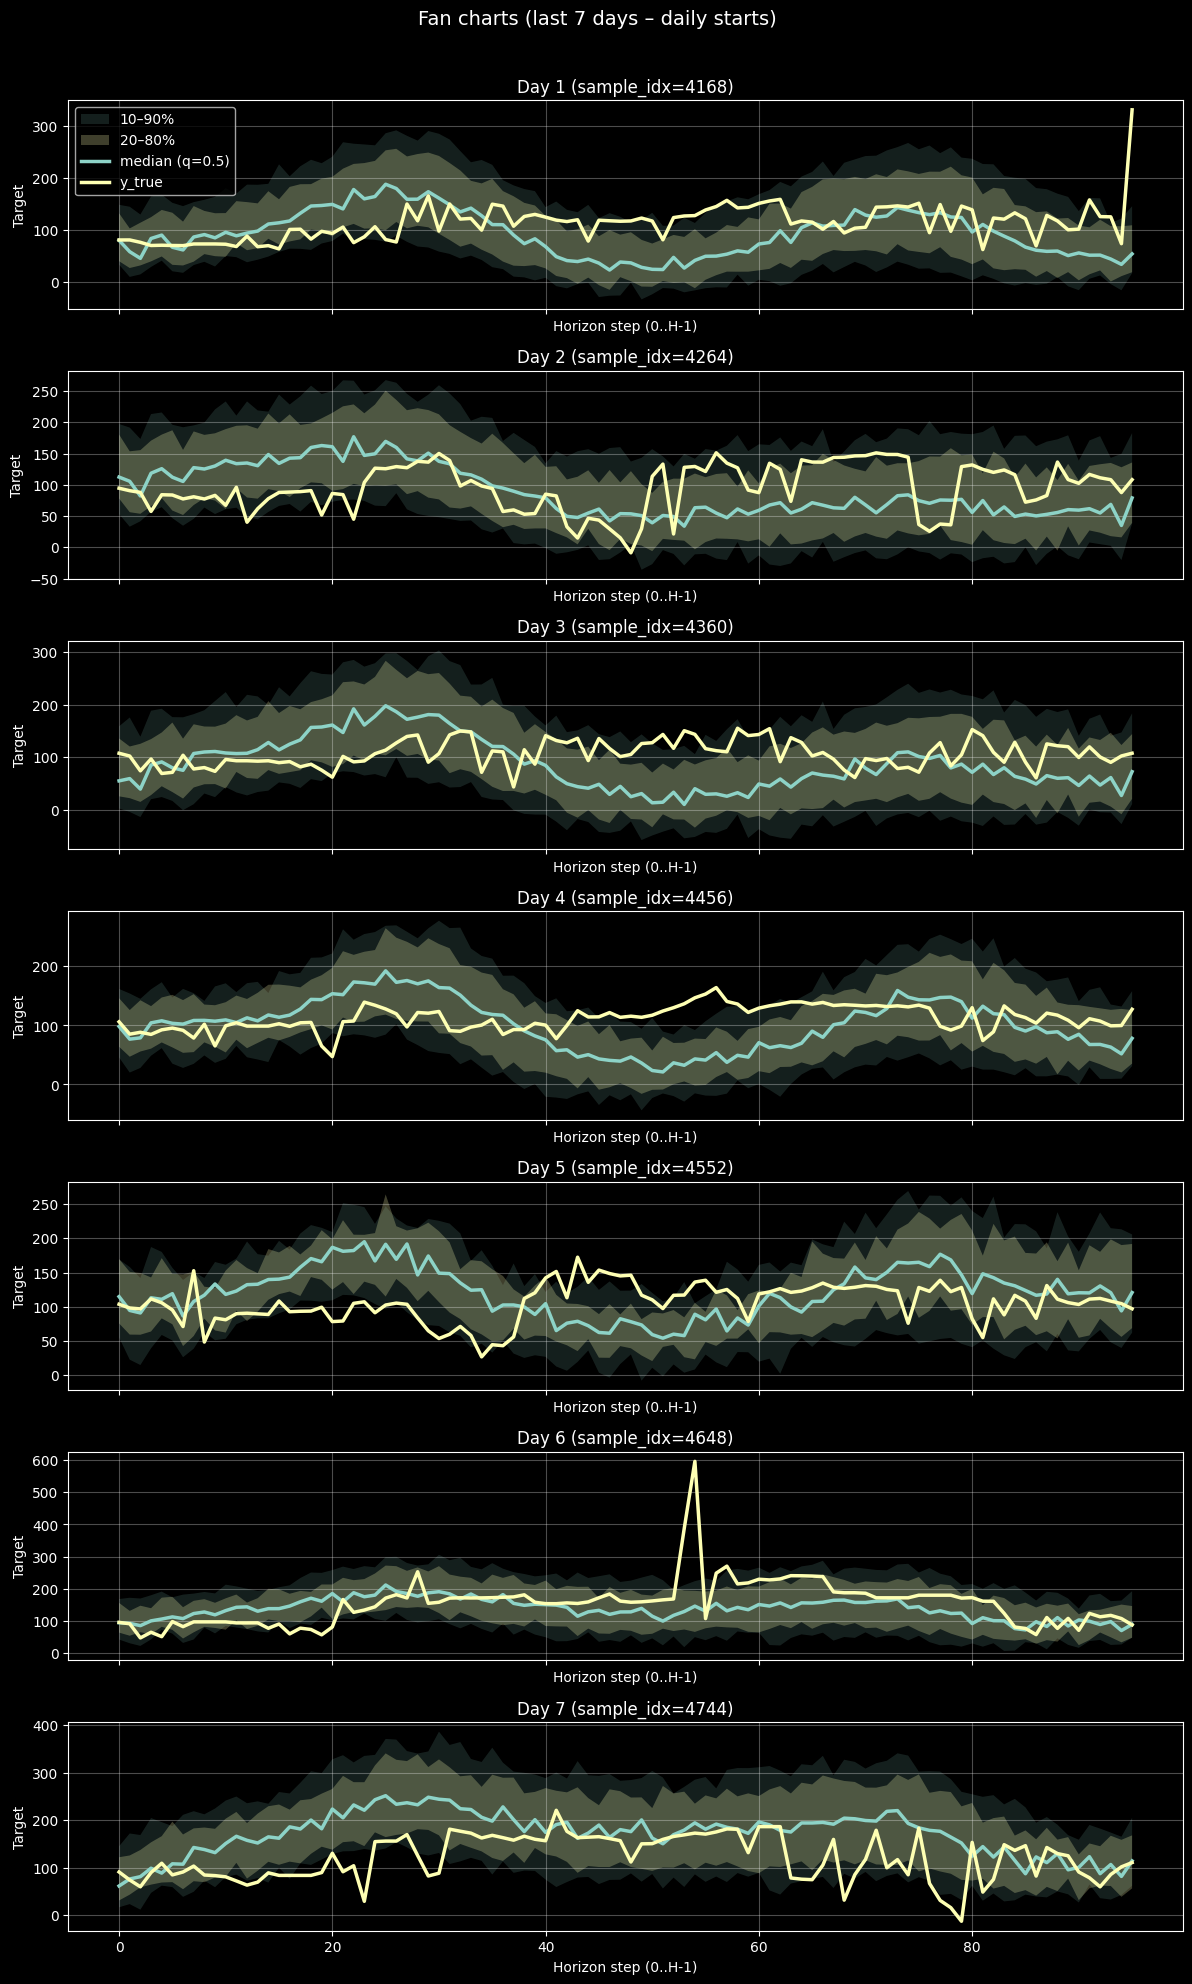

In [20]:
yhats7, ytrue7, metrics = predict_and_plot_last_7_days(
    model=model,
    prepared=prepared,
    device=device,
    split="test",
    days=7,
    steps_per_day=96,
    suptitle="Fan charts (last 7 days – daily starts)",
)
